In [1]:
import os, glob, re, random, gzip, json, pysam
from collections import Counter, defaultdict, OrderedDict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import seaborn as sns

# Cell quality control

In [2]:
params = []

# HG001
d = pd.read_excel("../../1_NanoStrandSeq/data/NanoStrandSeq_Summary.xlsx")
runs= [
    "20220418_S5CSTreat",
    "20220430_S5Merged", 
    "20220610_Treat", 
    "20220708_GM12878", 
    "20220708_GM12878R2", 
    "20220817_HG001", 
    "20220915_P1", 
    "20220916_P1", 
    "20220916_P2"]
control_cells = [
    "20220418_S5CSTreat.sc001",
    "20220418_S5CSTreat.sc002",
    "20220418_S5CSTreat.sc003",
    "20220418_S5CSTreat.sc004",
    "20220418_S5CSTreat.sc005",
    "20220418_S5CSTreat.sc006",
    "20220418_S5CSTreat.sc007",
    "20220418_S5CSTreat.sc008"]
d = d[[(run in runs) and (cell not in control_cells) for run, cell in d[["Run", "Cell"]].values]]
params.append(["NanoStrand-seq", 80000, 0.05, d])

# C57/DBA
d = pd.read_excel("../../1_NanoStrandSeq/data/NanoStrandSeq_Summary.xlsx")
runs= [
    "20220524_MEF", 
    "20220929_P1", 
    "20220929_P2", 
    "20221005_MEF", 
    "20221006_MEF"]
d = d[[run in runs for run in d["Run"]]]
params.append(["NanoStrand-seq.MM", 70000, 0.05, d])

# Strand-seq
d = pd.read_excel("../../2_StrandSeq/data/StrandSeq_Summary.xlsx")
d = d[d["Run"] == "20160928_PRJEB14185_CEU"]
params.append(["Strand-seq", 800000, 0.05, d])

# OP-Strand-seq
d = pd.read_excel("../../2_StrandSeq/data/StrandSeq_Summary.xlsx")
d = d[d["Run"] == "20210729_PRJNA742746_HG001"]
params.append(["OP-Strand-seq", 2000000, 0.05, d])

Total	Pass	Name
826	367	NanoStrand-seq
455	211	NanoStrand-seq.MM
132	94	Strand-seq
656	74	OP-Strand-seq


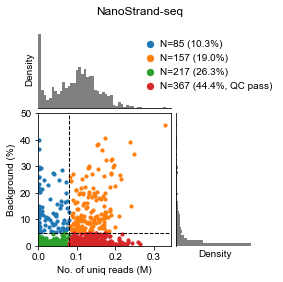

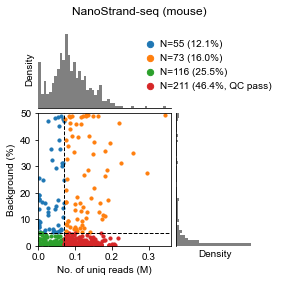

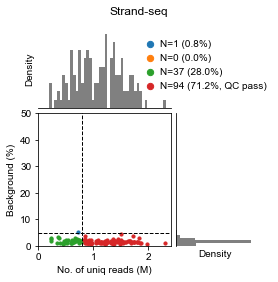

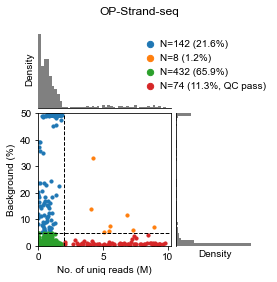

In [6]:
print("Total\tPass\tName")
for name, min_reads, max_bg, df in params:   
    df = df.copy()
    df["Background"] = np.nan_to_num(df["Background"], 0)
    
    array = [
        [df[(df["UniqReads"] < min_reads) & (df["Background"] >= max_bg)], "C0"],
        [df[(df["UniqReads"] >= min_reads) & (df["Background"] >= max_bg)], "C1"],
        [df[(df["UniqReads"] < min_reads) & (df["Background"] < max_bg)], "C2"],
        [df[(df["UniqReads"] >= min_reads) & (df["Background"] < max_bg)], "C3"]
    ]
    
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(2, 2, width_ratios=(1.7, 1), height_ratios=(1, 1.7),
                          left=0.15, right=0.9, bottom=0.15, top=0.9,
                          wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0])
    ax_histy = fig.add_subplot(gs[1, 1])
    
    ax_histx.set_facecolor("none")
    
    if name == "NanoStrand-seq.MM":
        plt.suptitle("NanoStrand-seq (mouse)")
    else:
        plt.suptitle(name)
    
    if True:
        plt.sca(ax)
        for i, (df1, color) in enumerate(array):
            xs = df1["UniqReads"] / 1000000
            ys = df1["Background"] * 100
            label = "N=%d (%.1f%%)" % (len(df1), len(df1)*100/len(df))
            if i == 3:
                label = "N=%d (%.1f%%, QC pass)" % (len(df1), len(df1)*100/len(df))
            plt.scatter(xs, ys, color=color, marker="o", s=10, 
                        label=label)
        plt.axvline(min_reads / 1e6, color="black", lw=1, ls="--")
        plt.axhline(max_bg * 100, color="black", lw=1, ls="--")
        xmax = max(df["UniqReads"]) / 1e6 * 1.05
        plt.xlim(0, xmax)
        plt.ylim(0, 50)
        plt.xlabel("No. of uniq reads (M)")
        plt.ylabel("Background (%)")
        plt.legend(loc="lower left", bbox_to_anchor=(0.7, 1.1), 
                   markerscale=2, handletextpad=0, frameon=False)
    
    if True:
        plt.sca(ax_histx)
        plt.hist(df["UniqReads"]/1e6, range=(0, xmax), bins=50, color="grey")
        plt.xlim(0, xmax)
        ax_histx.spines["top"].set_visible(False)
        ax_histx.spines["left"].set_visible(False)
        ax_histx.spines["right"].set_visible(False)
        plt.ylabel("Density")
        plt.xticks([])
        plt.yticks([])

    if True:
        plt.sca(ax_histy)
        plt.hist(df["Background"] * 100, range=(0, 50), bins=50, color="grey",
                 orientation="horizontal")
        plt.ylim(0, 50)
        ax_histy.spines["top"].set_visible(False)
        ax_histy.spines["bottom"].set_visible(False)
        ax_histy.spines["right"].set_visible(False)
        plt.xlabel("Density")
        plt.yticks([])
        plt.xticks([])
    
    plt.savefig("figures/cell_qc.%s.pdf" % name, dpi=300)
    
    df.to_csv("results/%s.tsv" % name, sep="\t")
    array[3][0].to_csv("results/%s.qc_pass.tsv" % name, sep="\t", index=False)
    print(len(df), len(df1), name, sep="\t")

# Comparison of background

In [7]:
array = []
for lib in ["Strand-seq", "OP-Strand-seq", "NanoStrand-seq"]:
    d = pd.read_csv("results/%s.qc_pass.tsv" % lib, sep="\t")
    d["Background"] = d["Background"] * 100
    print("-" * 80)
    print(lib)
    print("Mean:", np.mean(d["Background"]))
    print("Median:", np.median(d["Background"]))
    d["Method"] = lib
    array.append(d)
df = pd.concat(array, ignore_index=True)

--------------------------------------------------------------------------------
Strand-seq
Mean: 1.5099627659574468
Median: 1.3965
--------------------------------------------------------------------------------
OP-Strand-seq
Mean: 0.8868243243243243
Median: 0.6799499999999999
--------------------------------------------------------------------------------
NanoStrand-seq
Mean: 1.2815237057220707
Median: 0.8411


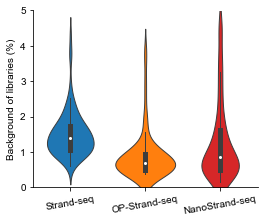

In [8]:
plt.figure(figsize=(3.8, 3.2))
ret = sns.violinplot(data=df, x="Method", y="Background", linewidth=1, density_norm="width")
colors = ["C0", "C1", "C3"]
for i in range(3):
    ret.collections[i * 2].set_facecolor(colors[i])
    ret.collections[i * 2 + 1].set_color("white")
    ret.lines[i * 2].set_linewidth(1)
    ret.lines[i * 2 + 1].set_linewidth(5)
plt.xlabel(None)
plt.xticks(rotation=10)
plt.ylabel("Background of libraries (%)")
plt.ylim(0, 5)
# plt.grid(axis="y", lw=1, ls="--")
ret.spines["top"].set_visible(False)
ret.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/cell_background.violinplot.pdf", dpi=300)

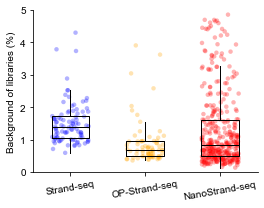

In [9]:
np.random.seed(0)
colors = ["blue", "orange", "red"]
plt.figure(figsize=(3.8, 3))
w = 0.5
for x, dat in enumerate(array):
    ys = dat["Background"]
    plt.boxplot([ys], positions=[x], widths=w, 
                showfliers=False, showcaps=False,
                medianprops={"color": "black"}, zorder=10)
    xs = np.random.random(len(ys)) * w - w/2 + x
    plt.scatter(xs, ys, marker="o", s=20, color=colors[x], edgecolor="none", alpha=0.3, clip_on=False)
plt.xticks(np.arange(3), ["Strand-seq", "OP-Strand-seq", "NanoStrand-seq"], rotation=10)
plt.ylim(0, 5)
plt.ylabel("Background of libraries (%)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/cell_background.pdf", dpi=300)

# Stat of depth of coverage

In [11]:
names = ["Strand-seq", "OP-Strand-seq", "NanoStrand-seq"]
for name in names:
    d = pd.read_csv("results/%s.qc_pass.tsv" % name, sep="\t")
    print(name, np.mean(d["GenomicDepth"]))

Strand-seq 0.08886503012121322
OP-Strand-seq 0.25956389468783864
NanoStrand-seq 0.2851362784089927
